# TRACES D'ANALYSES DES KERNELS

__Attention :__ Ce fichier utilisait une ancienne version du MBR_KERNEL (kernel customisé par mes soins). Elle était entre la version originale des Kernel Kaggle, qui proposait entre 500 et 600 features, et la version actuelle, qui en a moins de 50.

Je l'ai laissé dans le Repo, car il contient des éléments intéressants pour améliorer le feature engineering de la version en production :
1. La corrélation des features
2. L'importance des features pour la régression logistique et la Random Forest

Des premiers fichiers, issus d'un premier espace de travail que j'avais créé, sont aussi disponibles dans "old_workspace". J'ai été amené à recréer un environnement, car le premier buggait (le .gitignore de l'IDE prenait l'avantage sur le .gitignore du répertoire local et il était devenu impossible de pusher mes modifications).

In [1]:
import pandas as pd
import  mbr_kernel as mkn
from sklearn.impute import SimpleImputer
import numpy as np

import gc

#
import utilitaires_810 as u810

#
import time
from contextlib import contextmanager

# A remove quand traitement DF externalise
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

GIT_FOLDER = './'
INPUT_FOLDER = GIT_FOLDER + 'input_data/'

In [2]:
train_df = pd.read_csv('./input_data/application_train.csv')
print(train_df.shape)

(307511, 122)


In [3]:
with timer("application processing"):
    df = mkn.process_application(df=train_df)
    print("Application dataframe shape: ", df.shape)
with timer("Bureau and bureau_balance processing"):
    bureau_df = mkn.bureau_and_balance(path=INPUT_FOLDER)
    df = pd.merge(df, bureau_df, on='SK_ID_CURR', how='left')
    print("Bureau dataframe shape: ", bureau_df.shape)
    del bureau_df; gc.collect()
with timer("Previous application processing"):
    prevapp = mkn.previous_applications(path=INPUT_FOLDER)
    df = pd.merge(df, prevapp, on='SK_ID_CURR', how='left')
    print("Previous Application dataframe shape: ", prevapp.shape)
    del prevapp; gc.collect()
with timer("Pos-Cash processing"):
    pos_cash = mkn.pos_cash(path=INPUT_FOLDER)
    df = pd.merge(df, pos_cash, on='SK_ID_CURR', how='left')
    print("Pos-Cash dataframe shape: ", pos_cash.shape)
    del pos_cash; gc.collect()
with timer("Installment processing"):
    installments_payments = mkn.installments_payments(path=INPUT_FOLDER)
    df = pd.merge(df, installments_payments, on='SK_ID_CURR', how='left')
    print("Installement dataframe shape: ", installments_payments.shape)
    del installments_payments; gc.collect()
with timer("CC processing"):
    credit_card_balance = mkn.credit_card_balance(path=INPUT_FOLDER)
    df = pd.merge(df, credit_card_balance, on='SK_ID_CURR', how='left')
    print("CC dataframe shape: ", credit_card_balance.shape)
    del credit_card_balance; gc.collect()
df = u810.reduce_memory(df)

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/oc-ds-p07/utilitaires_810.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Forme du Dataframe apres traitement :  (307502, 122)


/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
/home/maximorose/git_repositories/oc-ds-p07/mbr_kernel.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Application dataframe shape:  (307502, 97)
application processing - done in 2s
Bureau dataframe shape:  (305811, 58)
Bureau and bureau_balance processing - done in 12s
Previous Application dataframe shape:  (338857, 110)
Previous application processing - done in 13s
Pos-Cash dataframe shape:  (337252, 7)
Pos-Cash processing - done in 7s
Installement dataframe shape:  (339587, 9)
Installment processing - done in 17s
CC dataframe shape:  (103558, 24)
CC processing - done in 6s


In [4]:
df.shape

(307502, 305)

In [5]:
days_credits_col = [col for col in df.columns if 'DAYS_CREDIT' in col]
dcc_df = df[days_credits_col]
dcc_df['TARGET'] = df['TARGET']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_np = imputer.fit_transform(dcc_df)
imputed_df = pd.DataFrame(imputed_np, columns=dcc_df.columns.tolist())

/tmp/ipykernel_18186/4044041812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc_df['TARGET'] = df['TARGET']


In [6]:
# Calculate the correlation matrix
correlation_matrix = imputed_df.corr()

# Sort the correlations with 'Target' in decreasing order
correlation_with_target = correlation_matrix['TARGET'].sort_values(ascending=False)

corr_to_target = correlation_with_target.reset_index()

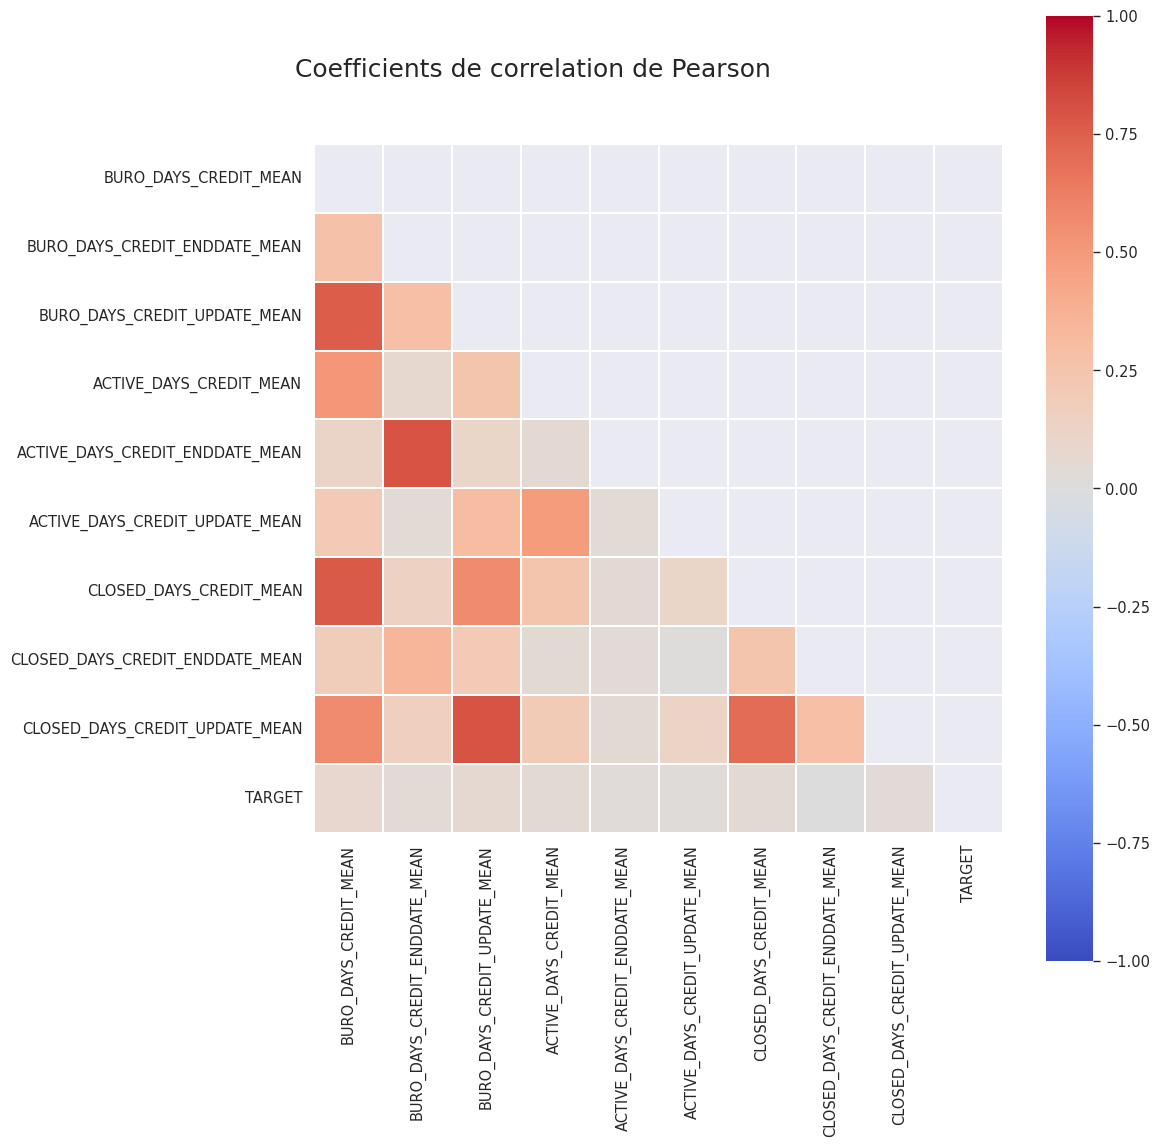

In [7]:
u810.display_corrmat(correlation_matrix, annot=False)

# Modelisation

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn

TEST_SIZE = 0.2
RANDOM_STATE = 42

## LogReg

In [10]:
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (246001, 303) // X_test : (61501, 303)
y_train : (246001,) // y_test : (61501,)


In [11]:
# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)

In [12]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

In [13]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
train_auc_score = auc(fpr, tpr)
train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
print("TRAIN F2 score", train_F2_score)
print("TRAIN AUC", train_auc_score)
print("TRAIN Recall", train_rappel)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc_score = auc(fpr, tpr)
test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
print("TEST F2 score", test_F2_score)
print("TEST AUC", test_auc_score)
print("TEST Recall", test_rappel)

TRAIN F2 score 0.397132663454265
TRAIN AUC 0.6696428524908615
TRAIN Recall 0.6714501510574018
TEST F2 score 0.39635453895639744
TEST AUC 0.6689299217203316
TEST Recall 0.6700906344410876


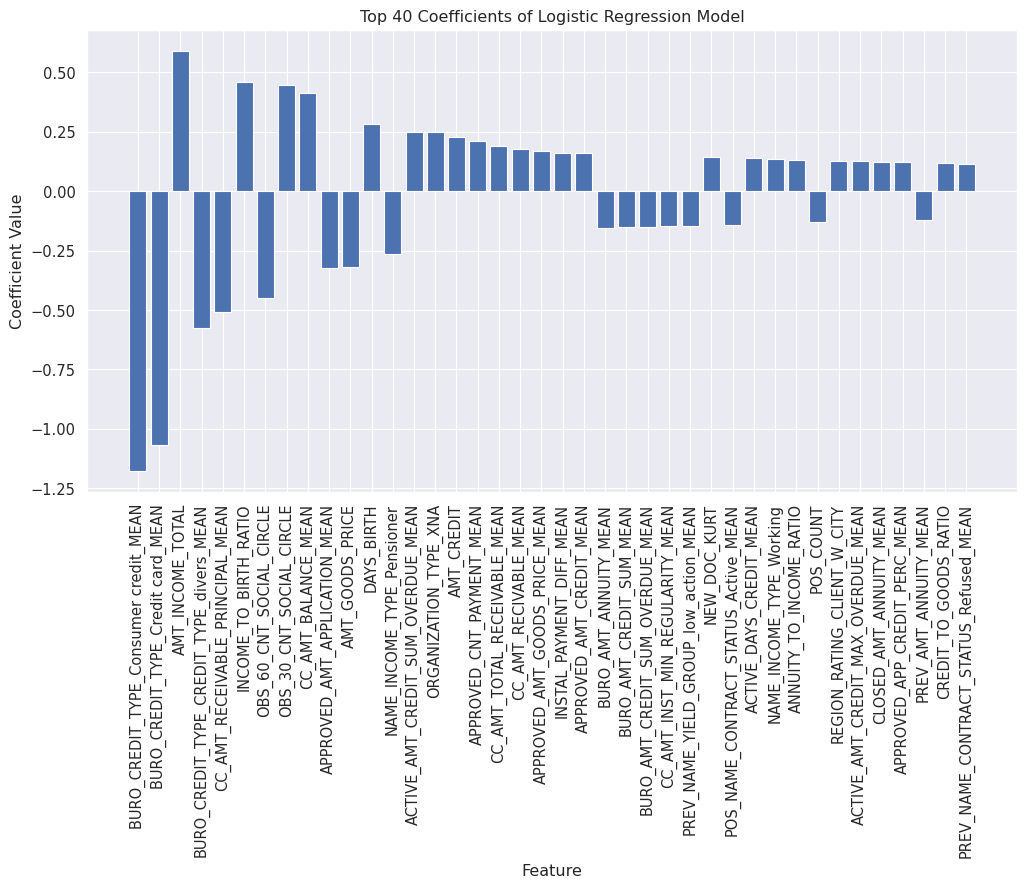

In [14]:
import matplotlib.pyplot as plt

coefficients = model['estimator'].coef_[0]
feature_names = np.array(X.columns.tolist())
# Sort coefficients in descending order and get the 40 largest coefficients
top40_coefficients = np.argsort(np.abs(coefficients))[::-1][:40]
# Plot the values of the selected coefficients
plt.figure(figsize=(12, 6))
plt.bar(range(len(top40_coefficients)), coefficients[top40_coefficients])
plt.xticks(range(len(top40_coefficients)), feature_names[top40_coefficients], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.title('Top 40 Coefficients of Logistic Regression Model')
plt.show()

## Random Forest

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = RandomForestClassifier()

model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator', RandomForestClassifier())])

In [16]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
train_auc_score = auc(fpr, tpr)
train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
print("TRAIN F2 score", train_F2_score)
print("TRAIN AUC", train_auc_score)
print("TRAIN Recall", train_rappel)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
test_auc_score = auc(fpr, tpr)
test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
print("TEST F2 score", test_F2_score)
print("TEST AUC", test_auc_score)
print("TEST Recall", test_rappel)

TRAIN F2 score 0.8996357969885304
TRAIN AUC 0.9755064318279303
TRAIN Recall 1.0
TEST F2 score 0.2508682328907048
TEST AUC 0.5937112942571967
TEST Recall 0.2473313192346425


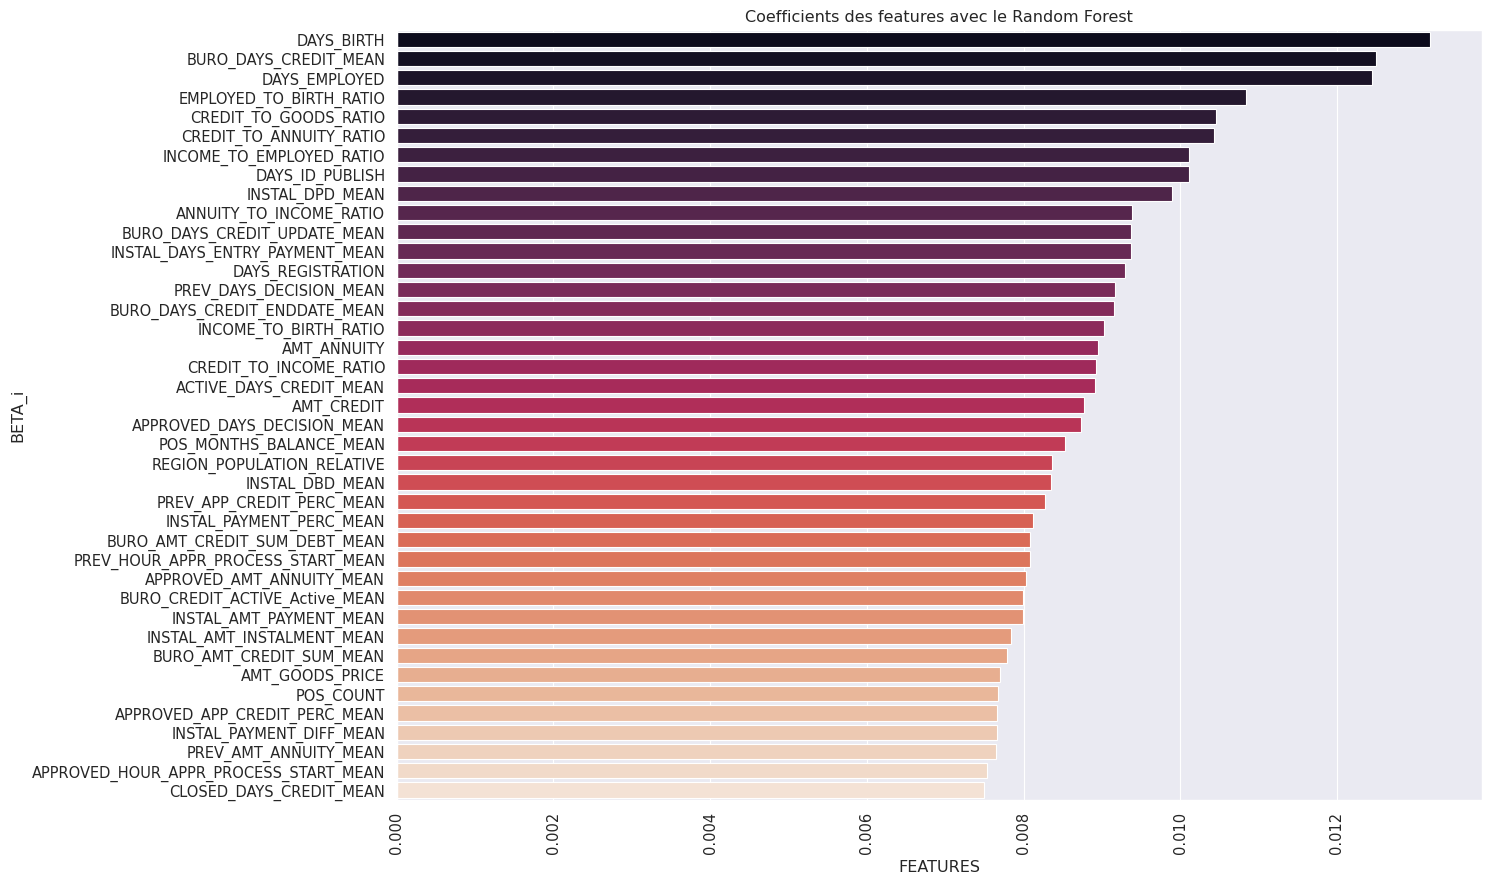

,feature,poids
6,DAYS_BIRTH,0.013190
95,BURO_DAYS_CREDIT_MEAN,0.012497
7,DAYS_EMPLOYED,0.012445
44,EMPLOYED_TO_BIRTH_RATIO,0.010842
39,CREDIT_TO_GOODS_RATIO,0.010455
38,CREDIT_TO_ANNUITY_RATIO,0.010429
42,INCOME_TO_EMPLOYED_RATIO,0.010117
9,DAYS_ID_PUBLISH,0.010110
271,INSTAL_DPD_MEAN,0.009892
40,ANNUITY_TO_INCOME_RATIO,0.009387


In [17]:
u810.feature_importance_rf(xtrain=X_train, modelrf=model['estimator'], size=40)